<a href="https://colab.research.google.com/github/khongpan/DOpredict/blob/master/AquaIoT_DOpredict00001_07_Release_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [320]:
#@title Import nessary module
import xml.etree.ElementTree as etree
import requests
import datetime as dt
from pytz import timezone
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
                               
import numpy as np
from scipy.optimize import curve_fit
from google.colab import files

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

#global varible
tz_th = timezone('Etc/GMT-7')
start_date = dt.datetime(2020, 7, 24, 0, 0, 0, 0, tzinfo=tz_th)

time_s=[]
do_s=[]
temp_s=[]
light_s=[]
do_calc_s=[]

Kphoto=0.01
Kload=0.01
Kdissolve=0.01

Kp_s=[]
Kd_s=[]
Kl_s=[]
E_s=[]





In [321]:
#@title Helper function
def PhotoSynthesisDO(intensity,limit) :
  return intensity*np.exp(1-intensity/limit)


def DOsatCalc(t) :
  return 14.6-0.386*t+(6.54e-3)*t*t-(4.86e-5)*t*t*t

def DOnightCalc(t,a,b,c) :
  return (a * np.exp(-b * t) + c)
bounds=([-10,0.01,0], [10., 0.3, 20.])

def DOmodelCalcDOs(sampling,do_t0,Kp,Kl,Kd,temp_s,light_s) :

  calc_range = range(1,sampling,1)
  do_calc_s=[]
  do=do_t0
  do_calc_s.append(do)
  for i in calc_range :
    #print(i)
    do=do+Kp*PhotoSynthesisDO(light_s[i-1],1000)-Kl+Kd*(DOsatCalc(temp_s[i])-do)
    do_calc_s.append(do)
  
  return do_calc_s

def DOmodelCalcDOs2(sampling,do_t0,Kp,Kl,Kd,temp_s,light_s,limit) :

  calc_range = range(1,sampling,1)
  do_calc_s=[]
  do=do_t0
  do_calc_s.append(do)
  for i in calc_range :
    #print(i)
    do=do+Kp*PhotoSynthesisDO(light_s[i-1],limit)-Kl+Kd*(DOsatCalc(temp_s[i])-do)
    do_calc_s.append(do)
  
  return do_calc_s


m_do_t0 = 0
m_temp_s=[]
m_light_s=[]
m_fit_len=0

def DOmodelInit4Fit(do_t0,temp_s,light_s,fit_len) :
  global m_do_t0
  global m_temp_s
  global m_light_s
  global m_fit_len

  m_do_t0=do_t0
  m_temp_s=temp_s
  m_light_s=light_s
  m_fit_len=fit_len

  return


def DOmodelCalcDOs4Fit(t,kp,kl,kd) :
  global m_fit_len 
  global m_do_t0
  global m_temp_s
  global m_light_s
  return DOmodelCalcDOs(m_fit_len,m_do_t0,kp,kl,kd,m_temp_s,m_light_s)

def DOmodelCalcDOs4Fit2(t,kp,kl,kd,limit) :
  global m_fit_len 
  global m_do_t0
  global m_temp_s
  global m_light_s
  return DOmodelCalcDOs2(m_fit_len,m_do_t0,kp,kl,kd,m_temp_s,m_light_s,limit)
  
  

server = 'agritronics.nstda.or.th'
script_path = '/ws/get.php?'
appkey = '0c5a295bd8c07a080d5306'
network_id = 'AQUA-IOT-02'
node_id = '4096'

def DownloadData(io_number,date):

  times=[]
  values=[]
  url = 'http://'+server+script_path+'appkey='+appkey+'&p='\
                 + network_id+','+node_id+','+io_number+','+date
  #print(url)
  page = requests.get(url)
  root = etree.fromstring(page.content)
  io=root.find('IO')
  if io is None :
    return times,values
  for d in io.findall('Data'):
     t=d.find('IODateTime').text
     v=float(d.find('Value').text)
     times.append(t)
     values.append(v)
  return times,values

def SetSite(nid):
  global network_id
  network_id=nid


URL = 'https://notify-api.line.me/api/notify'
  
  
def send_message(token, msg, img=None):
    """Send a LINE Notify message (with or without an image)."""
    headers = {'Authorization': 'Bearer ' + token}
    payload = {'message': msg}
    files = {'imageFile': open(img, 'rb')} if img else None
    r = requests.post(URL, headers=headers, params=payload, files=files)
    if files:
        files['imageFile'].close()
    return r.status_code

def SendReport():
  #token='qRYJdSgArMOyVVfNkCNoNcKW1np1NCQQNFNgvXwU6yS' #หอยอวบแมงสาบอ้วน
  token='3ta99RpoHh43W4Nzhdcpx7Ej6OhpBzMVhcCHovEa02l'#DO and weather
  status=send_message(token, 'DO predict','do.jpg')
  return status

  




In [322]:
#@title Download and Prepare data function
io_do = '300'
io_temp = '304'
io_light = '307'
 

global start_date
date_txt=''
 
  
def PrepareData():
  global do_s
  global time_s
  global temp_s
  global light_s
  global date_txt
  do_s=[]
  temp_s=[]
  light_s=[]
  time_s=[]
  day_range=range(0,1)
  for day in day_range:
      date=start_date + dt.timedelta(days=day)
      date_txt = date.strftime('%Y-%m-%d')
    
      times=[]
      values=[]
      times,values = DownloadData(io_do,date_txt)
      do_s.extend(values)
      time_s.extend(times)

      times=[]
      values=[]
      times,values = DownloadData(io_temp,date_txt)
      temp_s.extend(values)
      #time_s.extend(times)

      times=[]
      values=[]
      times,values = DownloadData(io_light,date_txt)
      light_s.extend(values)
      #time_s.extend(times)

In [323]:
#@title Fit Model function
def FitDOmodel():
  
  
  time_all_s = np.linspace(0,(len(do_s)-1)*24/288,len(do_s))

 
  night_fit_begin = round(12*18)
  night_fit_time = 6
  night_fit_point = round(night_fit_time*12)
  night_fit_end = night_fit_begin+night_fit_point-1


  y_fit=do_s[night_fit_begin:night_fit_end+1]
  x_fit=np.linspace(0,night_fit_point-1,night_fit_point)
  x_fit=x_fit.astype(np.float64)
  DOmodelInit4Fit(do_s[night_fit_begin],temp_s[night_fit_begin:night_fit_end+1],
                  np.array(light_s[night_fit_begin:night_fit_end+1])*0,
                  night_fit_point
                 )
  popt, pcov = curve_fit(DOmodelCalcDOs4Fit, x_fit, y_fit, maxfev=1600,
                         #bounds=([-0.0001,0.,0.], [0., 1., 2.])
                         #bounds=([0.,0.,0.], [0.001, 0.4, 0.2])
                        )
  coff_night=popt
  kp_night=popt[0]
  kl_night=popt[1]
  kd_night=popt[2]
  #print('night',popt)
  y_fit_night=DOmodelCalcDOs(night_fit_point,do_s[night_fit_begin],
                             kp_night,kl_night,kd_night,
                             temp_s[night_fit_begin:night_fit_end+1],
                             np.array(light_s[night_fit_begin:night_fit_end+1])*0
                            )
  
  day_fit_begin = round(12*7)
  day_fit_hours = 11
  day_fit_point = round(day_fit_hours*12)
  day_fit_end = day_fit_begin+day_fit_point-1

  
  y_fit=do_s[day_fit_begin:day_fit_end+1]
  x_fit=np.linspace(0,day_fit_point-1,day_fit_point)
  x_fit=x_fit.astype(np.float64)
  DOmodelInit4Fit(do_s[day_fit_begin],temp_s[day_fit_begin:day_fit_end+1],
                  light_s[day_fit_begin:day_fit_end+1],day_fit_point)
  popt, pcov = curve_fit(DOmodelCalcDOs4Fit2, x_fit, y_fit, maxfev=1600,
                         bounds=([0.,0.,0.,1599], [0.0005, 0.2, 0.1, 1600])
                         #bounds=([0.,0.,0.04,1599], [0.0005, 0.2, 0.045, 1600])
                        )
  coff_day=popt
  kp_day=popt[0]
  kl_day=popt[1]
  kd_day=popt[2]
  l_limit=popt[3]
  #print('day',popt)

  y_fit_day=DOmodelCalcDOs2(day_fit_point,do_s[day_fit_begin],
                           kp_day,kl_day,kd_day,
                           temp_s[day_fit_begin:day_fit_end+1],
                           light_s[day_fit_begin:day_fit_end+1],
                           l_limit 
                           )


  plt.rcParams["figure.figsize"] = (10,5)
  plt.title(network_id+' '+date_txt)
  plt.ylim(0,15)
  plt.xlim(0,24)
  ax = plt.axes()
  ax.grid()
  ax.xaxis.set_major_locator(MultipleLocator(3))
  ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
  ax.xaxis.set_minor_locator(MultipleLocator(1))
  #plt.figure(1)
  plt.scatter(time_all_s,do_s,c='g', s=4,
           label='Sensor DO')
  plt.plot(time_all_s[day_fit_begin:day_fit_end+1],y_fit_day, c='r', 
           label='day fit  : a=%5.5f, b=%5.3f, c=%5.3f e=%5.3f' %tuple(coff_day))
  plt.plot(time_all_s[night_fit_begin:night_fit_end+1],y_fit_night, c='b',
           label='night fit: a=%5.5f, b=%5.3f, c=%5.3f' %tuple(coff_night))
  plt.plot(time_all_s[day_fit_begin:day_fit_end+1],
           np.array(light_s[day_fit_begin:day_fit_end+1])/1000*10.0, 
           c='orange', label='Sun light intensity'
          )
  plt.legend(loc='upper left')
  #plt.savefig('do.jpg')  
  plt.show()

  Kp_s.append(kp_day)
  Kl_s.append(kl_day)
  Kd_s.append(kd_day)
  E_s.append(np.average(light_s)*24.*60.*60./1000000)


AQUA-IOT-13


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


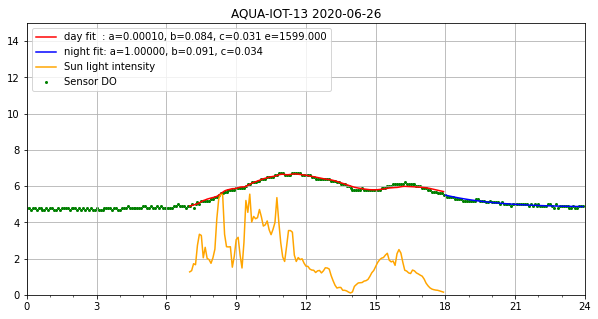

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


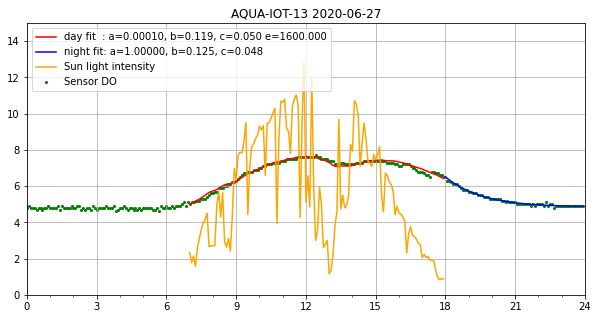

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


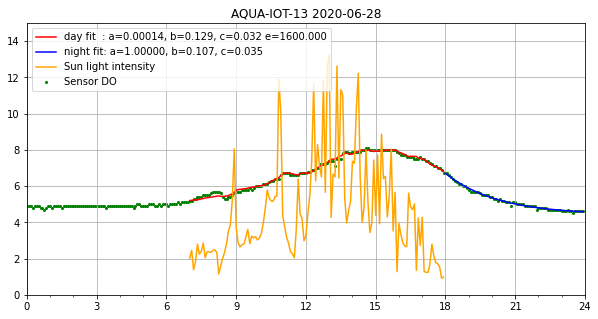

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


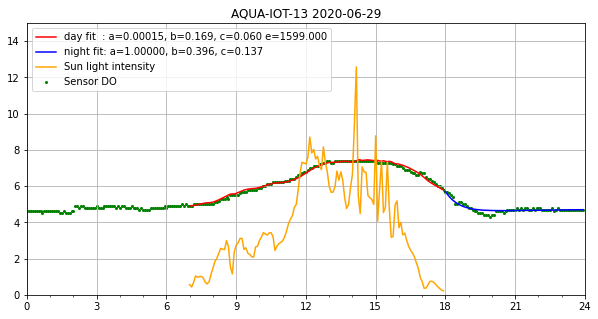

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


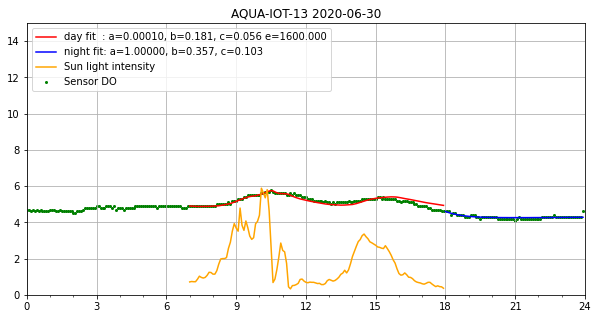

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


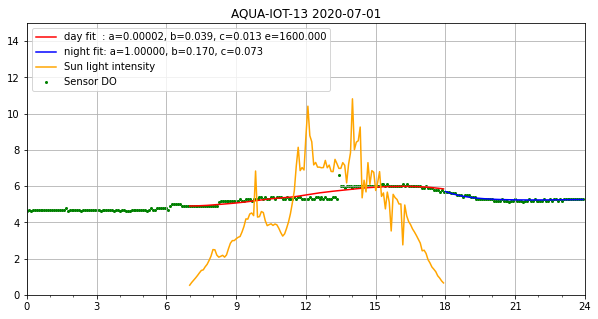

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


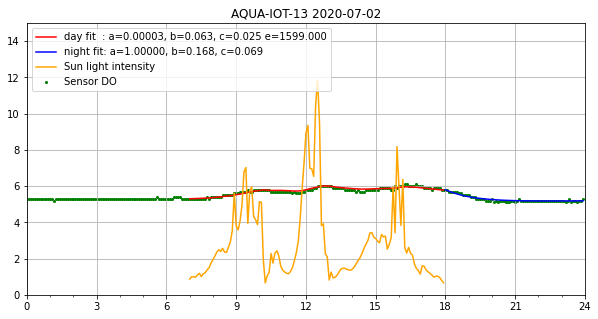

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


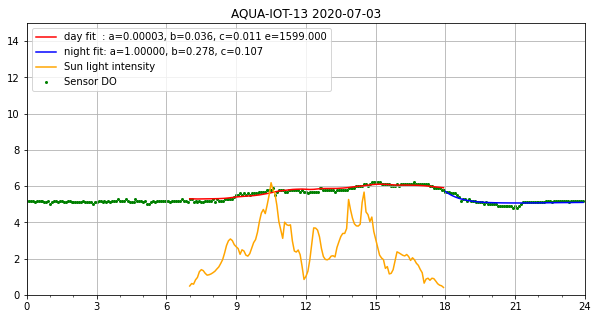

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


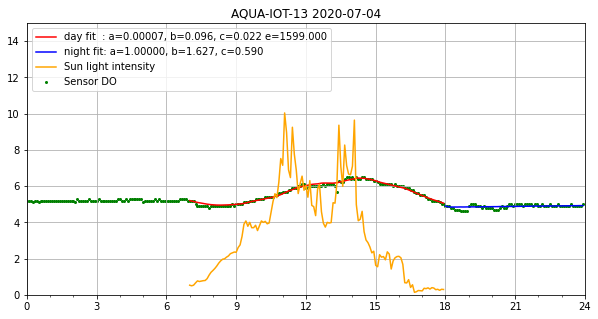

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


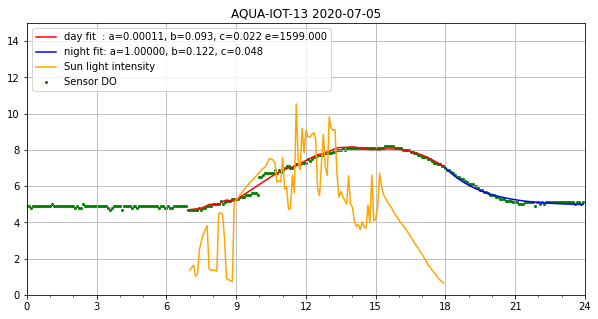

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


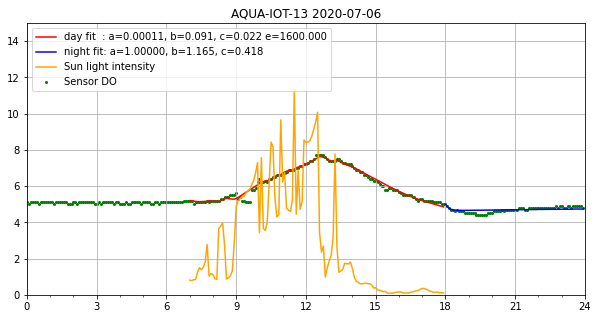

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


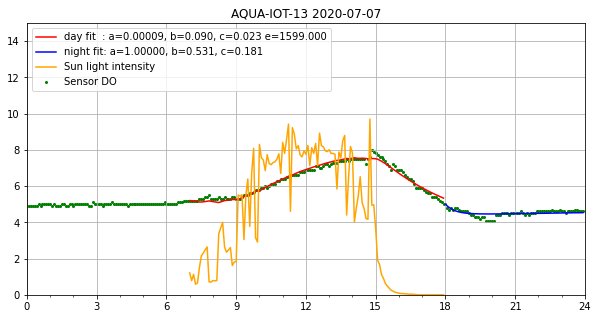

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


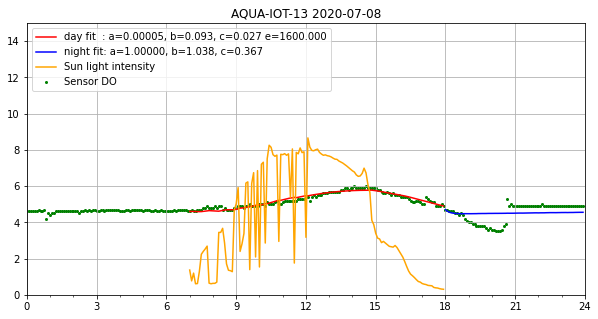

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


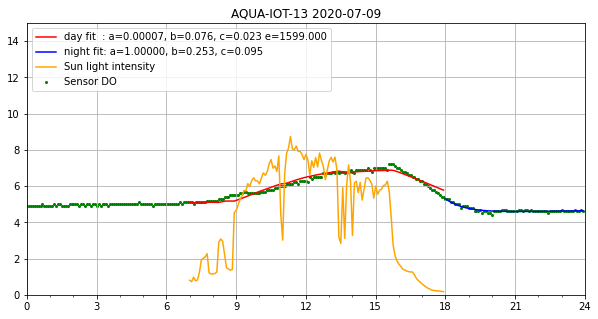

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


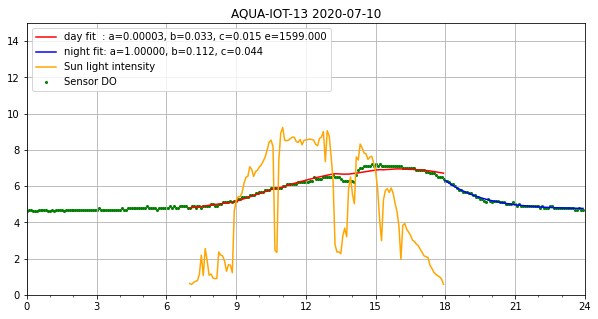

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


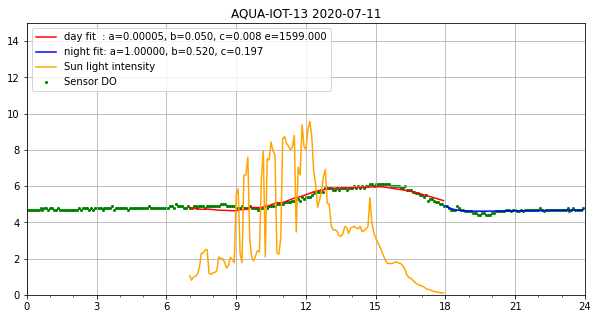

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


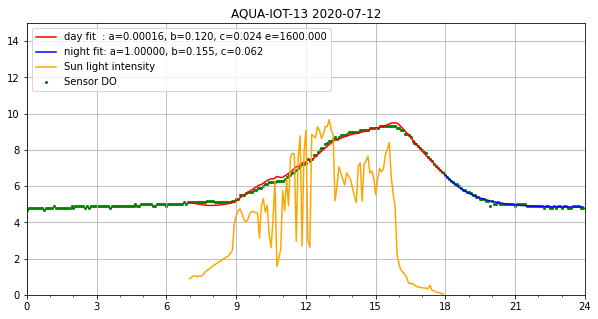

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


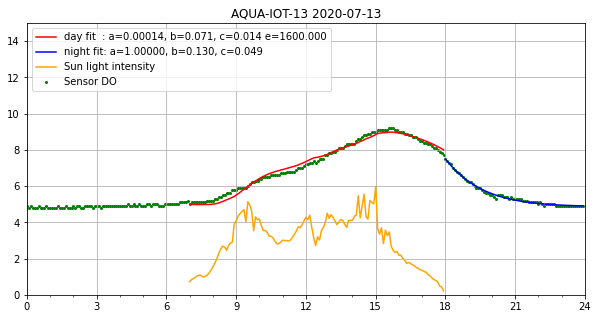

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


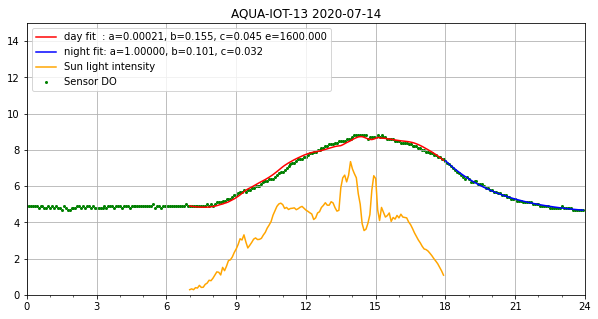

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


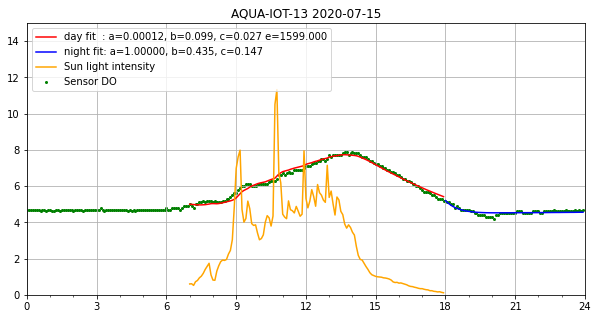

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


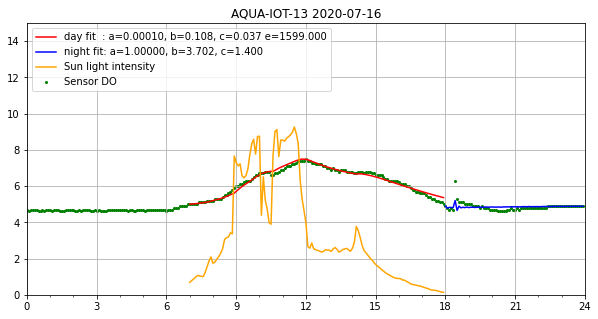

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


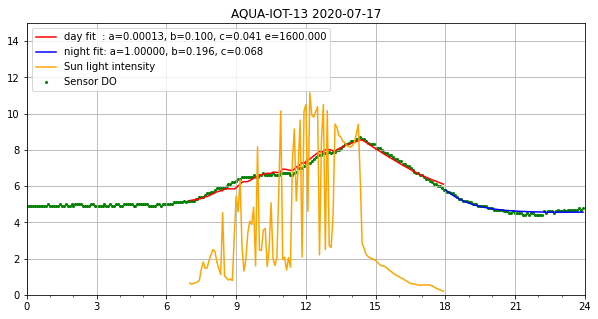

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


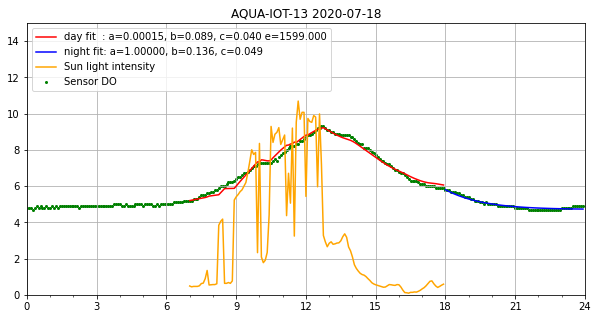

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


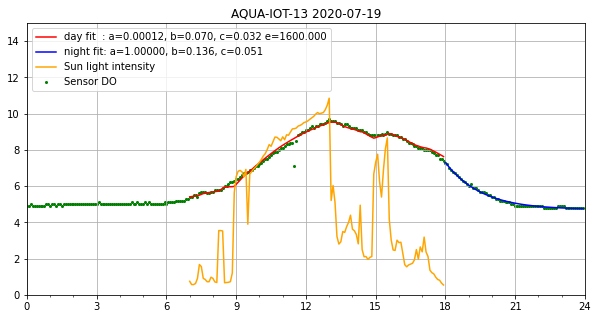

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


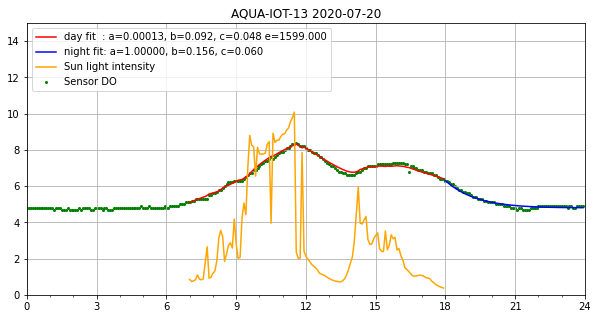

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


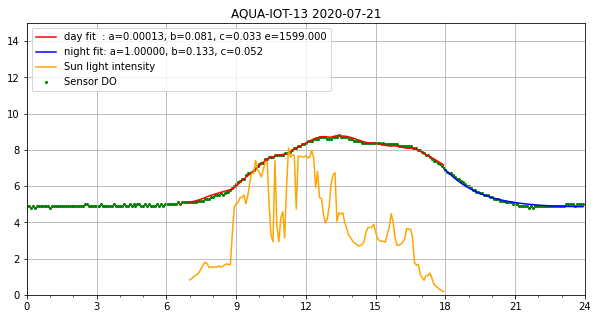

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


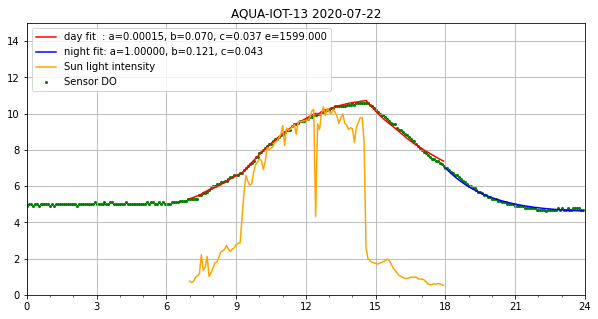

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


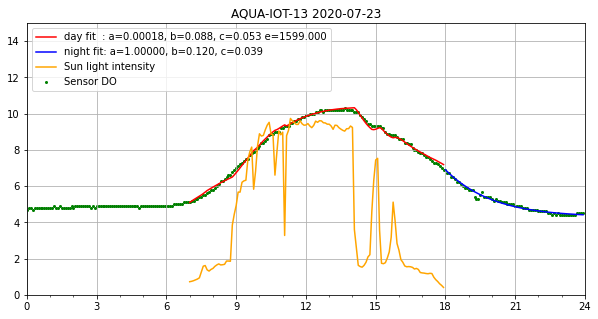

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


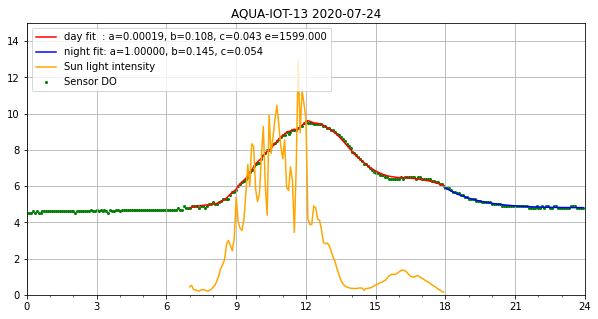

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


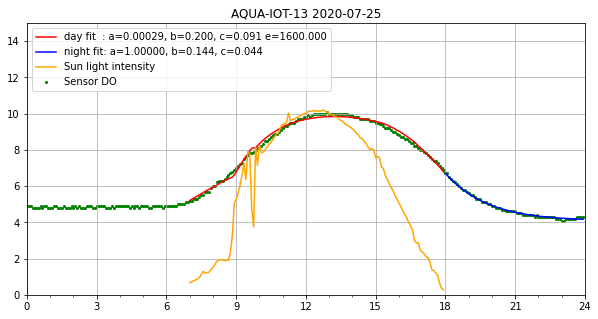

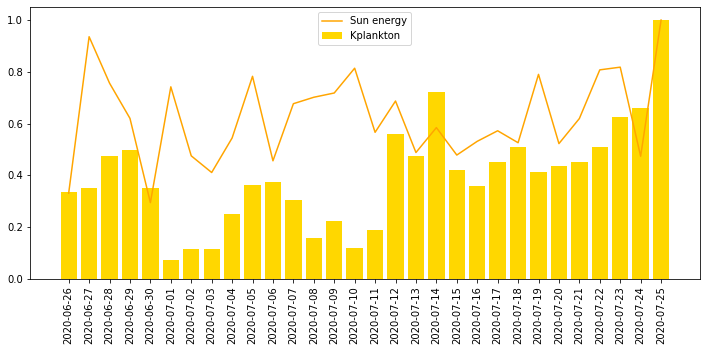

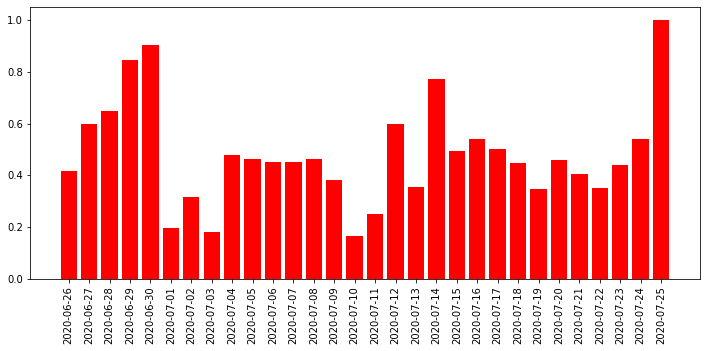

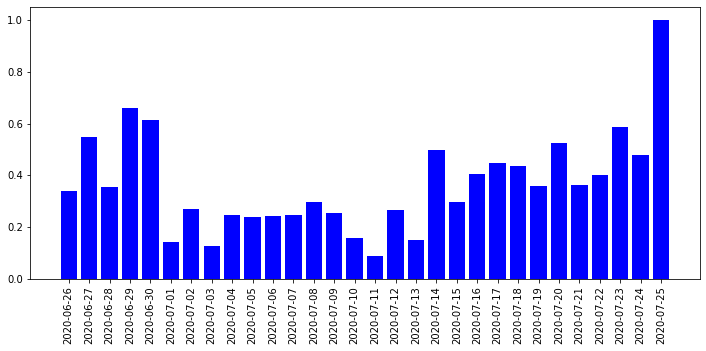

In [324]:
#@title Main Program
SiteLists=[
           #'AQUA-IOT-01',
           #'AQUA-IOT-02',
           #'AQUA-IOT-03',
           #'AQUA-IOT-04',
           #'AQUA-IOT-05',
           #'AQUA-IOT-06',
           #'AQUA-IOT-07',
           #'AQUA-IOT-08',
           #'AQUA-IOT-09',
           #'AQUA-IOT-10',
           #'AQUA-IOT-11',
           #'AQUA-IOT-12',
           'AQUA-IOT-13',
           #'AQUA-IOT-14',
           #'AQUA-IOT-15'
          ]
  
days_range = range(0,45,1)
day_txt_s=[]

for site in SiteLists :
  SetSite(site)
  print(site)
  Kp_s=[]
  Kl_s=[]
  Kd_s=[]
  reference_date = dt.datetime(2020, 6, 16, 0, 0, 0, 0, tzinfo=tz_th)
  for d in days_range :
    start_date = reference_date + dt.timedelta(days=d)
    PrepareData()
    if(len(do_s)!=288) :
      continue
    day_txt_s.append(start_date.strftime('%Y-%m-%d'))
    FitDOmodel()
    #SendReport()

  x_s=np.linspace(1,len(Kp_s),len(Kp_s))

  plt.rcParams["figure.figsize"] = (12,5)

  #plt.figure(1)
  #fig,ax1=plt.subplots()
  #ax1.bar(x_s,Kp_s/np.amax(Kp_s),color='gold',label='Kphoto')
  #ax2=ax1.twinx()
  #ax2.plot(x_s,E_s,color='orange', label='Sun energy')
  #plt.xticks(x_s,day_txt_s,rotation=90)
  #plt.show()

  plt.figure(1)
  plt.bar(x_s,Kp_s/np.amax(Kp_s),color='gold',label='Kplankton')
  plt.plot(x_s,E_s/np.amax(E_s),color='orange', label='Sun energy')
  plt.xticks(x_s,day_txt_s,rotation=90)
  plt.legend()
 

  plt.figure(2)
  plt.bar(x_s,Kl_s/np.amax(Kl_s),color='red',label='Kload')
  plt.xticks(x_s,day_txt_s,rotation=90)
  plt.legend

  plt.figure(3)
  plt.bar(x_s,Kd_s/np.amax(Kd_s),color='blue',label='Kdissolve')
  plt.xticks(x_s,day_txt_s,rotation=90)
  plt.show()
  plt.legend



[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]


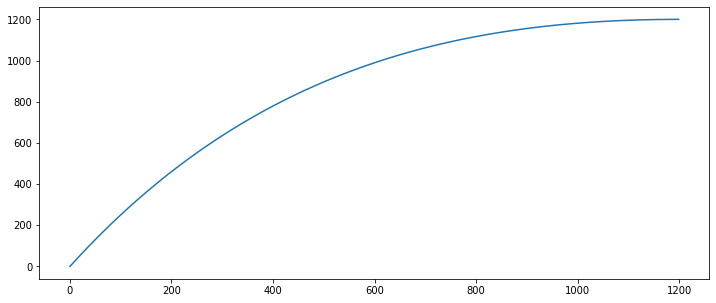

In [325]:

#!pwd
#!ls -la

#test = plt.figure()
#plt.plot([[1, 2, 3], [5, 2, 3]])
#plt.savefig('test.jpg')
#files.download('test.jpg')

#token='qRYJdSgArMOyVVfNkCNoNcKW1np1NCQQNFNgvXwU6yS'
#token='3ta99RpoHh43W4Nzhdcpx7Ej6OhpBzMVhcCHovEa02l'#DO and weather
#send_message(token, 'hello')
#send_message(token, 'hello','test.jpg')

limit =1200
def PhotoSynthesisResponse(i) :
  return i*np.exp(1-i/limit)

x_s= np.linspace(0.,limit-1,limit)
print(x_s[0:12])

y_s= PhotoSynthesisResponse(x_s)

plt.plot(x_s,y_s)





